## Terms for Use
Solvers are responsible for complying with all terms of use for the data sources they access.  All code in this document is provided using the [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).  The examples have been tested using Python 3 but have not been tested under Python 2.  Note that data providers may have changed their APIs or data formats after this notebook was published.

### Boring Details
The code cells below set up the notebook environment and load necessary libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.style.use("seaborn-dark")
import os
import json
import pandas as pd
from dateutil.parser import parse # To convert strings to timestamps
import warnings
import urllib3
http = urllib3.PoolManager()
GFC_HOME = os.path.abspath("../../..")
auth_file_path = os.path.join(GFC_HOME, "src", "resources", "auth.json")
with open(os.path.join(GFC_HOME, auth_file_path), "r") as f:
    api_key_dict = json.load(f)
data_path = os.path.join(GFC_HOME, "data")

## [US Energy Information Administration](https://www.eia.gov/)
The US Energy Information Administration (EIA) provides open data related to energy production and use for electricity, petroleum, and natural gas.  They provide a REST API that can be queried for this data, with documentation at https://www.eia.gov/opendata/commands.php.  A free API Key is required and can be obtained from EIA.

### Example: Oil Production in Algeria

The query URL for EIA is of the form `http://api.eia.gov/series/?api_key=API_KEY&series_id=SERIES_ID`.  To find the series ID for the country of interest, go to https://www.eia.gov/totalenergy/data/browser/?tbl=T11.01A#/?f=M&start=197301&end=201507&charted=12 and select the country desired.  The next page will include the data.  

The returned result is a bytes object which encapsulates a string which in turn encapsulates a dict structure.  The code below pulls the data and converts it to a dict.

In [3]:
eia_key = api_key_dict["eia"]
EIA_URL = "http://api.eia.gov"
series_id = "TOTAL.PAPRPAG.M"
query_url = EIA_URL + "/series/?api_key={}&series_id={}".format(eia_key, series_id)
with warnings.catch_warnings(): # Suppresses the InsecureRequestWarning
    warnings.simplefilter("ignore")
    r = http.request("GET", query_url)
raw_data = eval(r.data.decode()) # Decode turns bytes to string, eval converts to dict
print(raw_data.keys())

dict_keys(['series', 'request'])


The data of interest is in the `series` field, which is a list of one item, which is itself a dict.  Let's look at the structure:

In [4]:
_data = raw_data["series"][0]
print(_data.keys())

dict_keys(['updated', 'name', 'series_id', 'units', 'start', 'data', 'end', 'f'])


The time series data is contained in the `data` element.  Other fields provide metadata such as start and end dates, frequency, and units.  For our data, it looks like this:

In [5]:
print(_data["data"][:4]) # Last 4 data items
print(_data["units"]) # Units of measure
print(_data["f"]) # Frequency, M = monthly

[['201812', 1242], ['201811', 1242], ['201810', 1242], ['201809', 1242]]
Thousand Barrels per Day
M


Individual data points for this series are of the format YYYYMM and newest elements are earliest in the list.  We will need to convert the string to dates.

In [6]:
_data = _data["data"]
_data =[(parse(x[0]+"01"), x[1]) for x in _data]
_ser = pd.Series([x[1] for x in _data], index=[x[0] for x in _data])
_ser = _ser.sort_index(ascending=True) # Underlying data is in reverse time order, so we need to sort.
_ser.head()

1973-01-01    1142.0
1973-02-01    1142.0
1973-03-01    1142.0
1973-04-01    1142.0
1973-05-01    1153.0
dtype: float64

After processing the data the monthly production series is shown below.

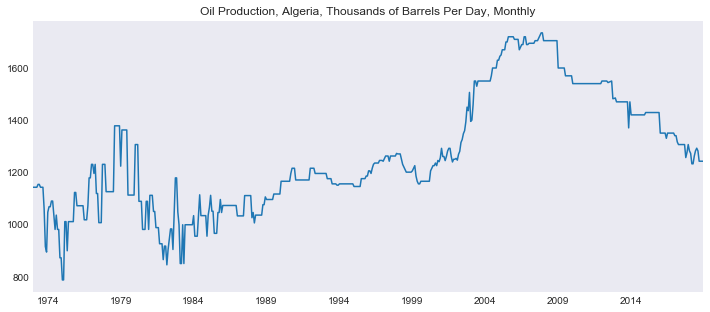

In [7]:
_ser.plot(figsize=(12,5), title="Oil Production, Algeria, Thousands of Barrels Per Day, Monthly");